In [1]:
# Standard library imports
from typing import Type, Any

# Third-party imports
import gymnasium as gym
import numpy as np
from numpy._typing import _ShapeLike
from tqdm import tqdm
import torch
from torch import Tensor
import torch.nn as nn
import gym_agent as ga


In [2]:
class DeepQNetwork(nn.Module):
    def __init__(self, n_inp: int, features: list[int], n_actions: int):
        super().__init__()

        # Create a list of layer sizes including input, hidden, and output layers
        layer_sizes = [n_inp] + features + [n_actions]
        # print(layer_sizes)

        # Initialize an empty sequential container
        self.net = nn.Sequential()

        # Loop through the layer sizes to create the network
        for i in range(len(layer_sizes) - 1):
            # Add a linear layer
            self.net.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            
            # Add ReLU activation function for all layers except the last one
            if i != len(layer_sizes) - 2:
                self.net.append(nn.ReLU(inplace=True))
        self.net.append(nn.Softmax())

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        # Pass the input state through the network
        return self.net(state)

In [3]:
from typing import overload
from torch.distributions import Categorical
class testPolicy: 
    def __init__(self, n_inp: int, features: list[int], n_actions: int, action_std: float = 0.6, device = 'cpu'):
        self.actor = DeepQNetwork(n_inp, features, n_actions)
        self.critic = DeepQNetwork(n_inp, features, n_actions=1) 
        self.actor.to(device) 
        self.critic.to(device)
        self.device = device
    
    def evaluate(self, state, action):
        action_probs = self.actor(state)
        dist = Categorical(action_probs)
        # action = dist.sample()
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_val = self.critic(state)
        return action_logprobs, state_val, dist_entropy    
    
    @overload
    def load_state_dict(self, policy) -> None: ...

    @overload 
    def load_state_dict(self, checkpoint_path) -> None: ... 

    def load_state_dict(self, a):  
        try: 
            if type(a) == testPolicy: 
                self.actor.load_state_dict(a.actor.state_dict())
                self.critic.load_state_dict(a.critic.state_dict())
            
            if type(a) == str: 
                checkpoint = torch.load(a)
                self.actor.load_state_dict(checkpoint['actor'])
                self.critic.load_state_dict(checkpoint['critic'])
        
        except:
            print("......Loading error......")
    


In [4]:
import torch.nn as nn 
from torch.distributions import MultivariateNormal, Categorical
import random 
class PPOAgent(ga.AgentBase): 
    def __init__(self,
            state_shape: _ShapeLike,
            action_shape: _ShapeLike,
            features: list[int],
            batch_size: int,
            buffer_size: int,
            update_every: int,
            device: str,
            seed,
            is_continuous=True,
            **kwargs) -> None: 
        # Explicitly pass `on_policy` and `buffer_size`
        super().__init__(state_shape, action_shape, batch_size, on_policy=True, buffer_size=buffer_size, update_every=update_every, device=device, seed=seed)
        
        self.is_continuous = is_continuous
        self.lr_critic = kwargs.get('lr_critic', 5e-4)
        self.lr_actor = kwargs.get('lr_actor', 5e-4)
        self.gamma = kwargs.get('gamma', 0.99) 
        self.action_std = kwargs.get('action_std', 0.6) 
        self.eps_clip = kwargs.get('eps_clip', 0.2) 
        self.lamda = kwargs.get('lamda', 0.9)

        self.n_inp = state_shape[0]

        self.policy = testPolicy(self.n_inp, features, action_shape[0], self.action_std, device=device)
        self.policy_old = testPolicy(self.n_inp, features, action_shape[0], self.action_std, device=device)
        self.policy_old.load_state_dict(self.policy)
        self.loss = nn.MSELoss()
        self.optimizer = torch.optim.Adam([
                        {'params': self.policy.actor.parameters(), 'lr': self.lr_actor},
                        {'params': self.policy.critic.parameters(), 'lr': self.lr_critic}
                    ])

        self.set_action_var(self.action_std)

    def set_action_var(self, new_action_std):
        self.action_std = new_action_std
        self.action_var = self.action_std**2
    
    @torch.no_grad()
    def act(self, state: np.ndarray) -> np.ndarray: 
        self.policy_old.actor.eval()
        if self.is_continuous:
            action_mean = self.policy_old.actor(state)
            cov_mat = torch.diag(self.action_var).unsqueeze(dim=0)
            dist = MultivariateNormal(action_mean, cov_mat)
        else:
            action_probs = self.policy_old.actor(state)
            dist = Categorical(action_probs)

        action = dist.sample()
        return action.detach().cpu().numpy()
    
    def TD_residual(self, rewards: torch.Tensor, states_values: torch.Tensor, next_states_values: torch.Tensor) -> torch.Tensor: 
        return rewards + self.gamma * next_states_values - states_values
    
    def GAE(self, states:torch.Tensor, next_states: torch.Tensor, rewards:torch.Tensor, terminals:torch.Tensor): 
        '''Calcualte general advantage estimation'''
        ratio = self.gamma * self.lamda
        advantages = []
        discounted_sum = 0
        for state, next_state, reward, terminal in zip(reversed(states), reversed(next_states), reversed(rewards), reversed(terminals)): 
            if terminal: 
                discounted_sum = 0 
            state_value = self.policy_old.critic(state) 
            next_state_value = self.policy_old.critic(next_state)
            # Calculate TD_residual
            discounted_sum = self.TD_residual(reward, state_value, next_state_value) + ratio*discounted_sum
            advantages.insert(0, discounted_sum)
        advantages = torch.tensor(advantages, dtype=torch.float32).to(self.device)

        # Normalize advantages
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-5)
        return advantages
    
    def returns_estimate(self, rewards: torch.Tensor, terminal: torch.Tensor, old_state_values: torch.Tensor, return_advantage = False) ->torch.Tensor:
        '''Using Monte Carlo to approximate advantage''' 
        # Calculate discounted returns
        returns = []
        discounted_sum = 0
        for r, done in zip(reversed(rewards), reversed(terminal)):
            if done:
                discounted_sum = 0
            discounted_sum = r + self.gamma * discounted_sum
            returns.insert(0, discounted_sum)
        returns = torch.tensor(returns, dtype=torch.float32).to(self.device)

        # Normalize returns
        returns = (returns - returns.mean()) / (returns.std() + 1e-5)
        if return_advantage: 
            advantage = returns = old_state_values.detach() 
            return returns, advantage
        return returns

    def learn(self, states, actions, rewards, next_states, terminal, using_gae = True) -> None:
        # Set networks to evaluation mode
        self.policy.actor.eval()
        self.policy.critic.eval()
        self.policy_old.actor.eval()
        self.policy_old.critic.eval()

        # Evaluate current and old policies
        logprobs, state_values, dist_entropy = self.policy.evaluate(states, actions)
        old_logprobs, old_state_values, _ = self.policy_old.evaluate(states, actions)

        # Set networks to training mode
        self.policy.actor.train()
        self.policy.critic.train()

        # Calculate advantage, returns. 
        if using_gae: 
            advantage = self.GAE(states=states, next_states=next_states, terminals=terminal, rewards=rewards)
            returns = self.returns_estimate(rewards, terminal, old_state_values, return_advantage=False)
        
        else: 
            returns, advantage = self.returns_estimate(rewards, terminal, old_state_values, return_advantage=True)

        # PPO ratio
        ratio = torch.exp(logprobs - old_logprobs.detach())

        # Surrogate loss
        surr1 = ratio * advantage
        surr2 = torch.clamp(ratio, 1 - self.eps_clip, 1 + self.eps_clip) * advantage

        # Total loss
        loss = -torch.min(surr1, surr2) + 0.5 * self.loss(state_values, returns) - 0.01 * dist_entropy

        # Backpropagation
        self.optimizer.zero_grad()
        loss.mean().backward()
        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(self.policy.actor.parameters(), max_norm=0.5)
        torch.nn.utils.clip_grad_norm_(self.policy.critic.parameters(), max_norm=0.5)
        self.optimizer.step()

        # Update old policy
        self.policy_old.load_state_dict(self.policy)


In [5]:
agent = PPOAgent(
    gamma=0.99,
    batch_size = False,
    state_shape = (8,),
    action_shape=(1,),
    action_space=[0,1,2,3],
    features=[128, 128],
    buffer_size=int(1e5),
    update_every=1,
    device = 'cuda' if torch.cuda.is_available() else 'cpu',
    seed = 42,
    lr_critic=5e-4,
    lr_actor = 5e-4,
    eps_clip = 0.2, 
    lamda=0.9, 
    is_continuous=False
)

In [6]:
n_games, max_t = 1000, 1000

In [7]:
env = ga.make('LunarLander-v2')

In [8]:
scores = agent.fit(env, n_games, max_t, save_best=True, save_last=False, progress_bar=tqdm)

  0%|          | 0/1000 [00:00<?, ?it/s]/home/quangminh/anaconda3/envs/ProjectDL/lib/python3.11/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/home/quangminh/anaconda3/envs/ProjectDL/lib/python3.11/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([86])) that is different to the input size (torch.Size([86, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 1/1000 [00:01<26:46,  1.61s/it, avg_score=-132, score=-132]/home/quangminh/anaconda3/envs/ProjectDL/lib/python3.11/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([69])) that is different to the input size (torch.Size([69, 1])). This will likely lead to incorre

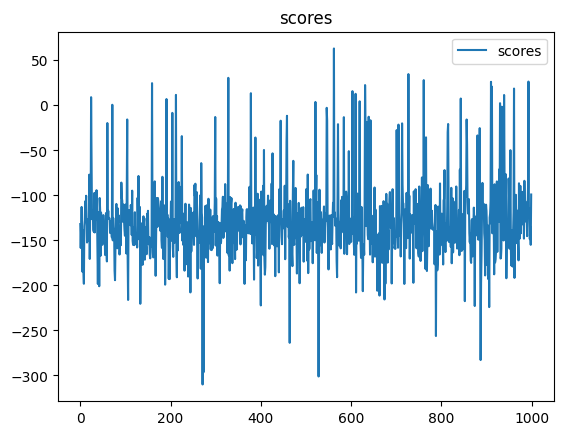

In [9]:
ga.plotting(np.arange(n_games), scores=scores)